**Import required modules**

C:\Users\pinak\Documents\GitHub\non-grad3D
Time taken by propagate is 94.00283670425415 seconds
Time taken by set_grid is 2.6846306324005127 seconds
Time taken by assign_pts is 3.189960479736328 seconds
Time taken by ready is 99.87863731384277 seconds
Time taken by compute_pd is 3.185309648513794 seconds


<IPython.core.display.Javascript object>


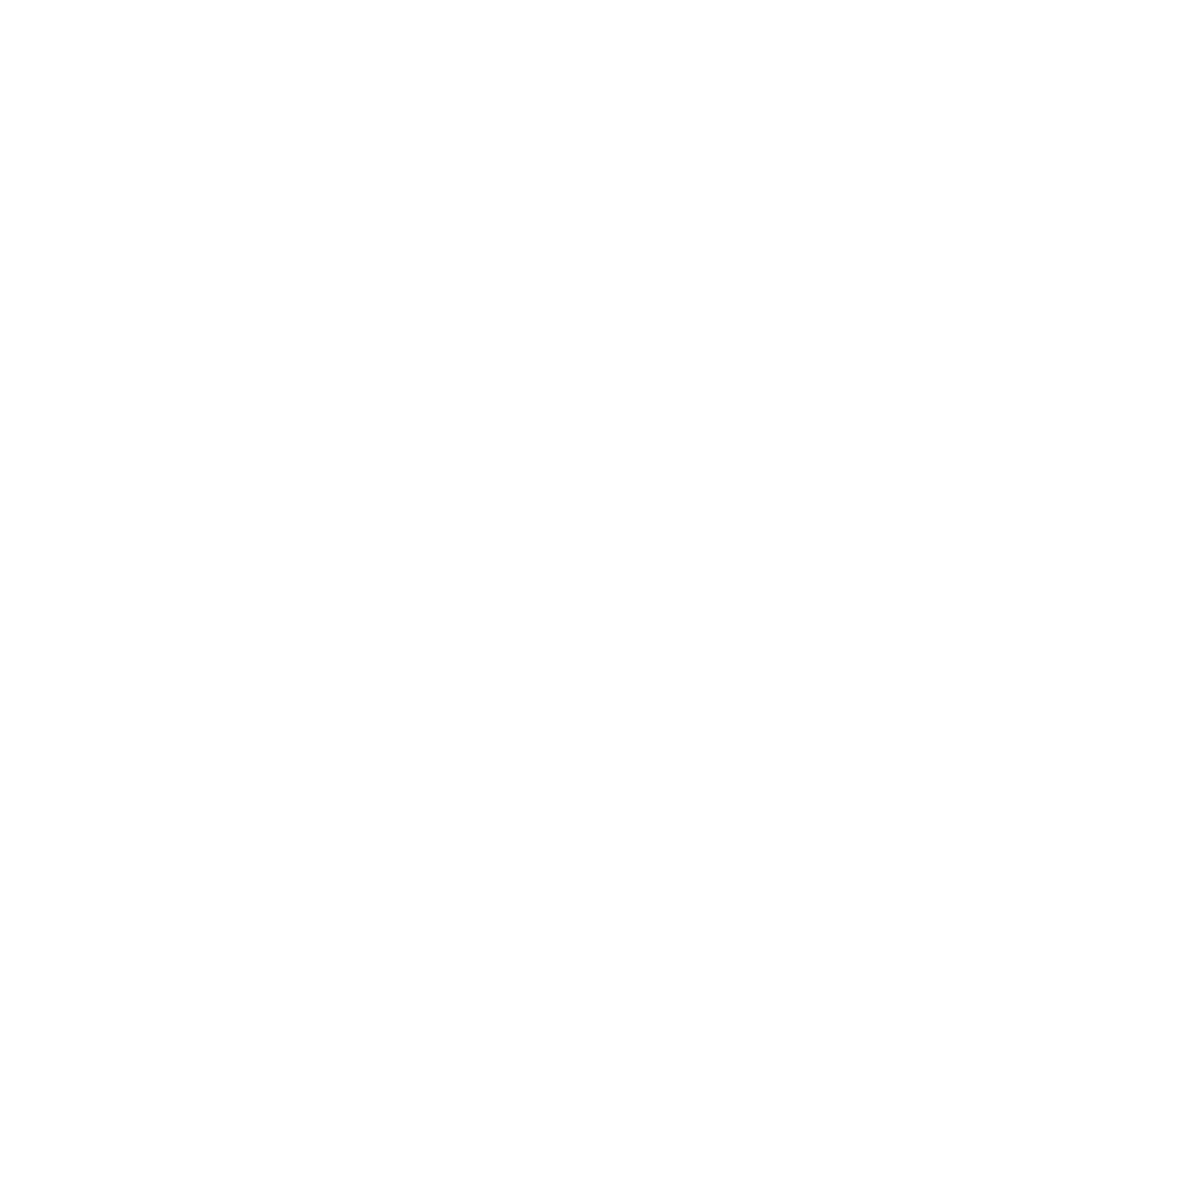

Time taken by compute_p1 is 2.953752279281616 seconds


<IPython.core.display.Javascript object>


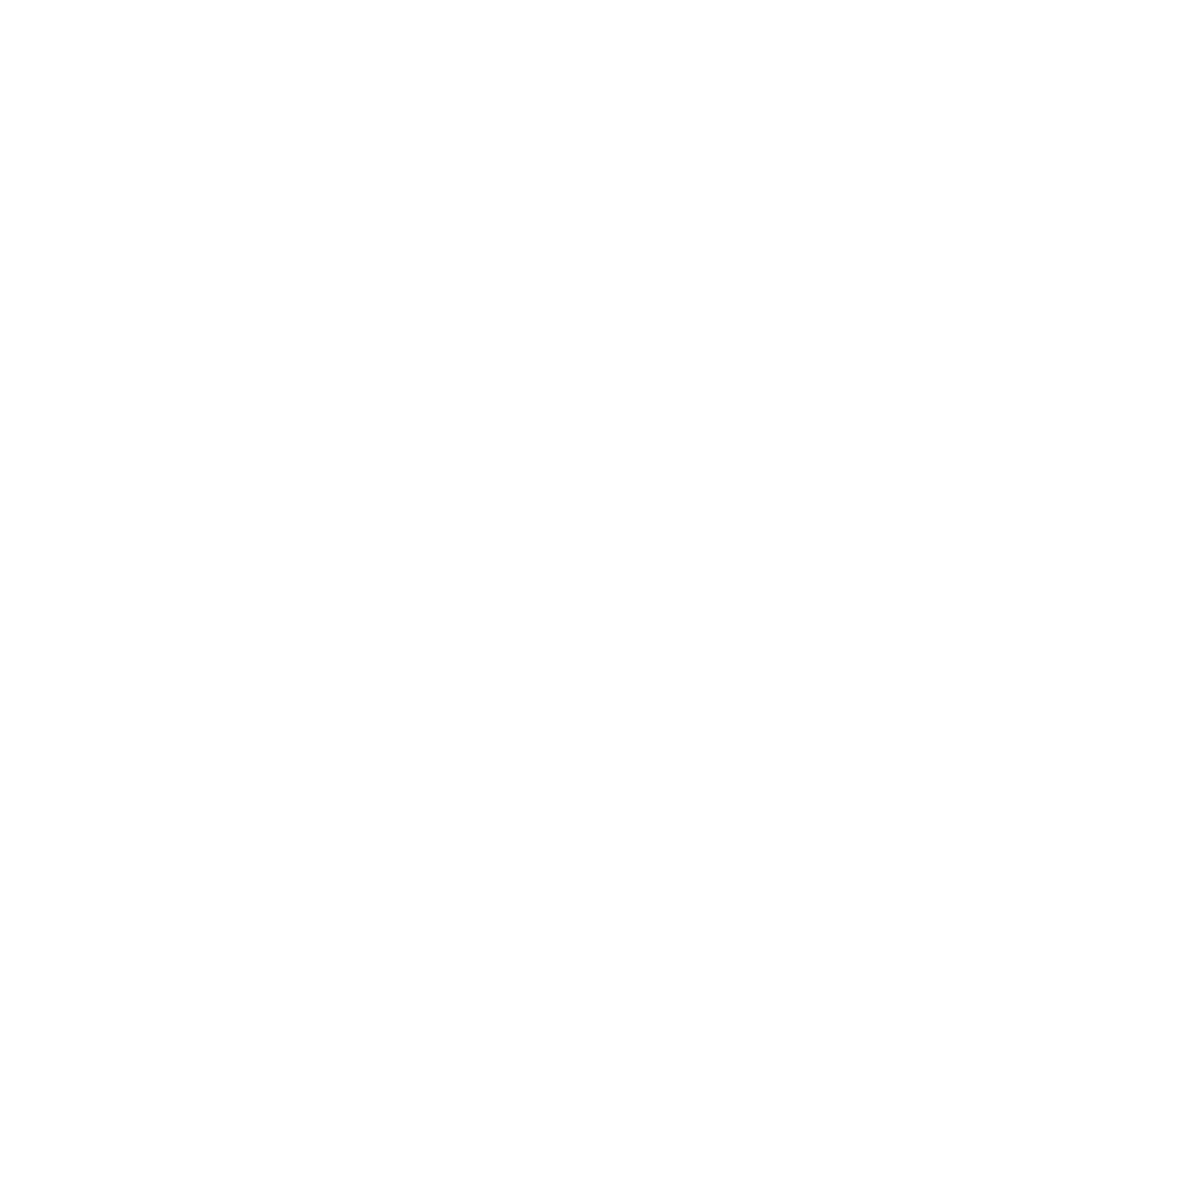

Time taken by compute_p2 is 3.065878391265869 seconds


<IPython.core.display.Javascript object>


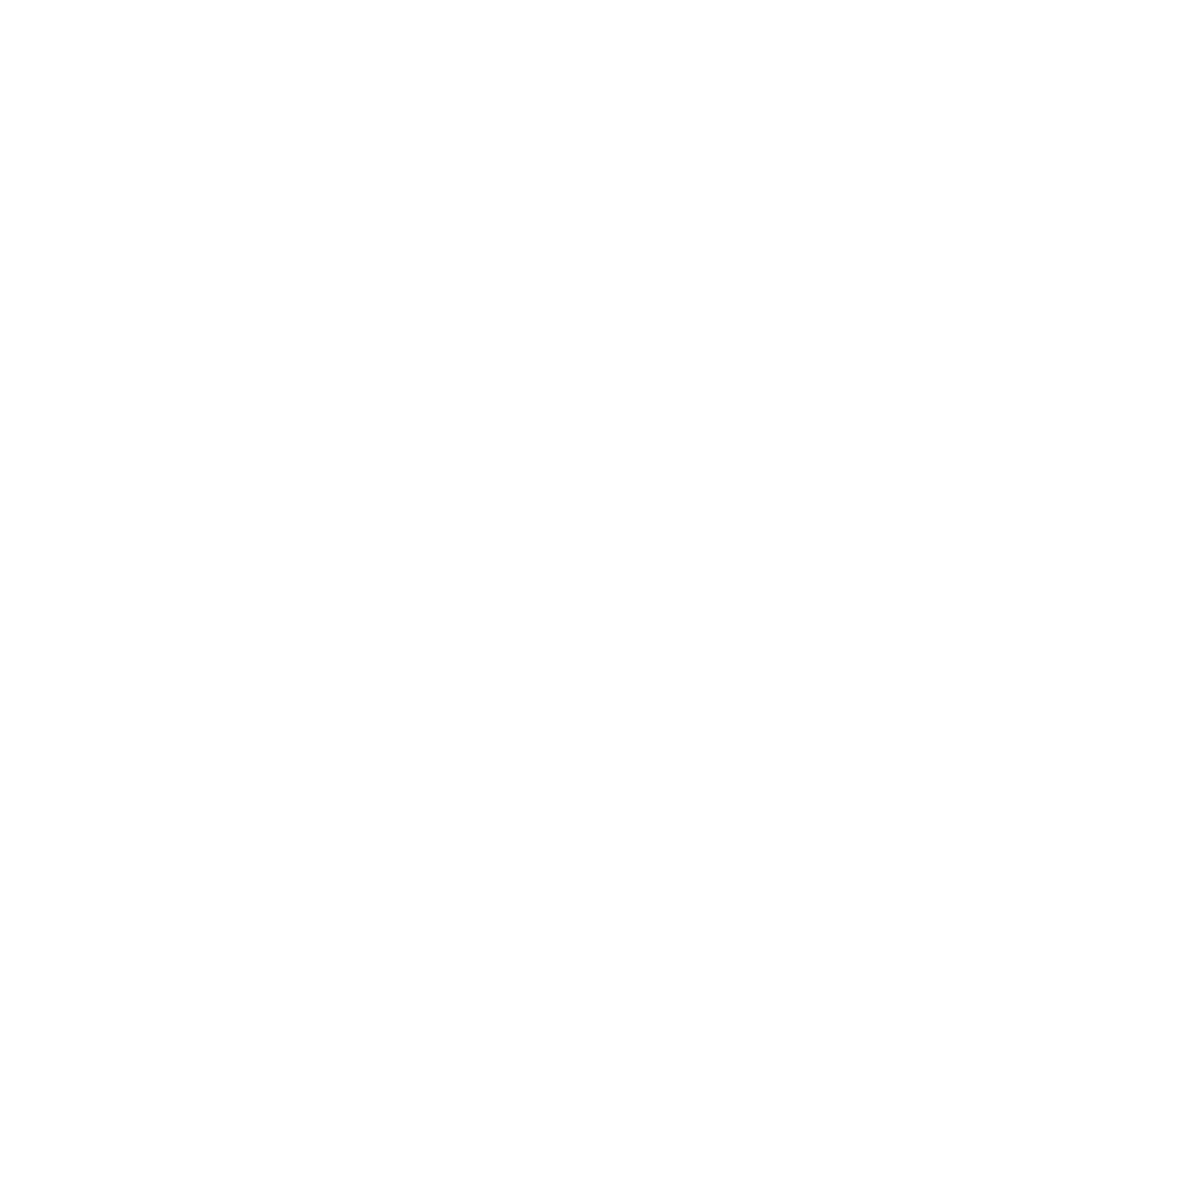

Time taken by compute_p2 is 3.053429126739502 seconds


<IPython.core.display.Javascript object>


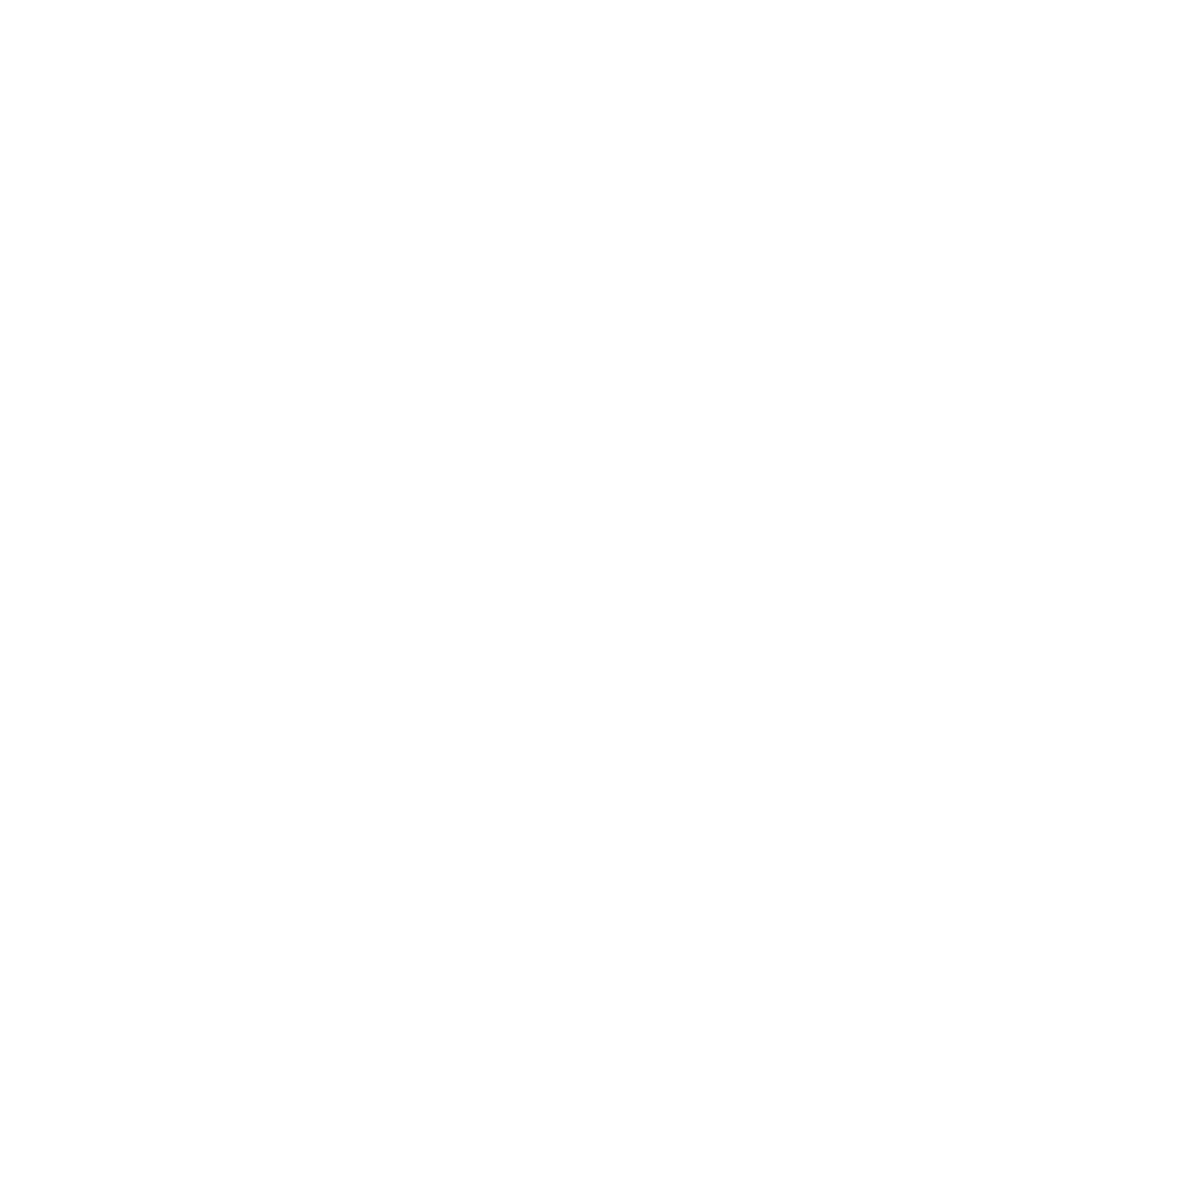

Time taken by compute_p1 is 2.815324068069458 seconds


<IPython.core.display.Javascript object>


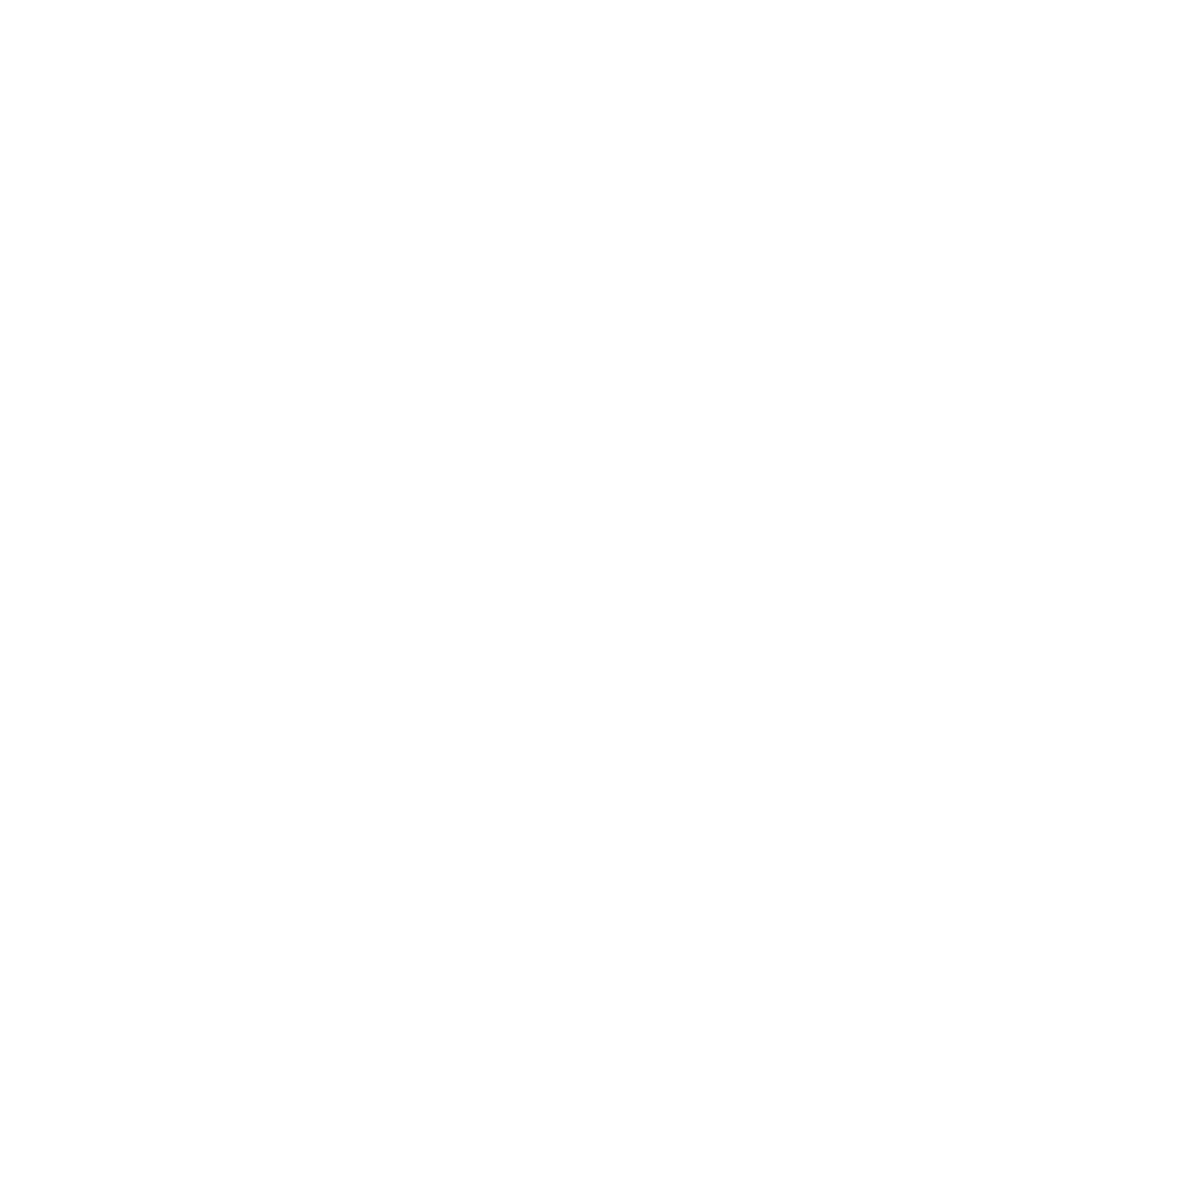

Time taken by compute_p2 is 3.04795241355896 seconds


<IPython.core.display.Javascript object>


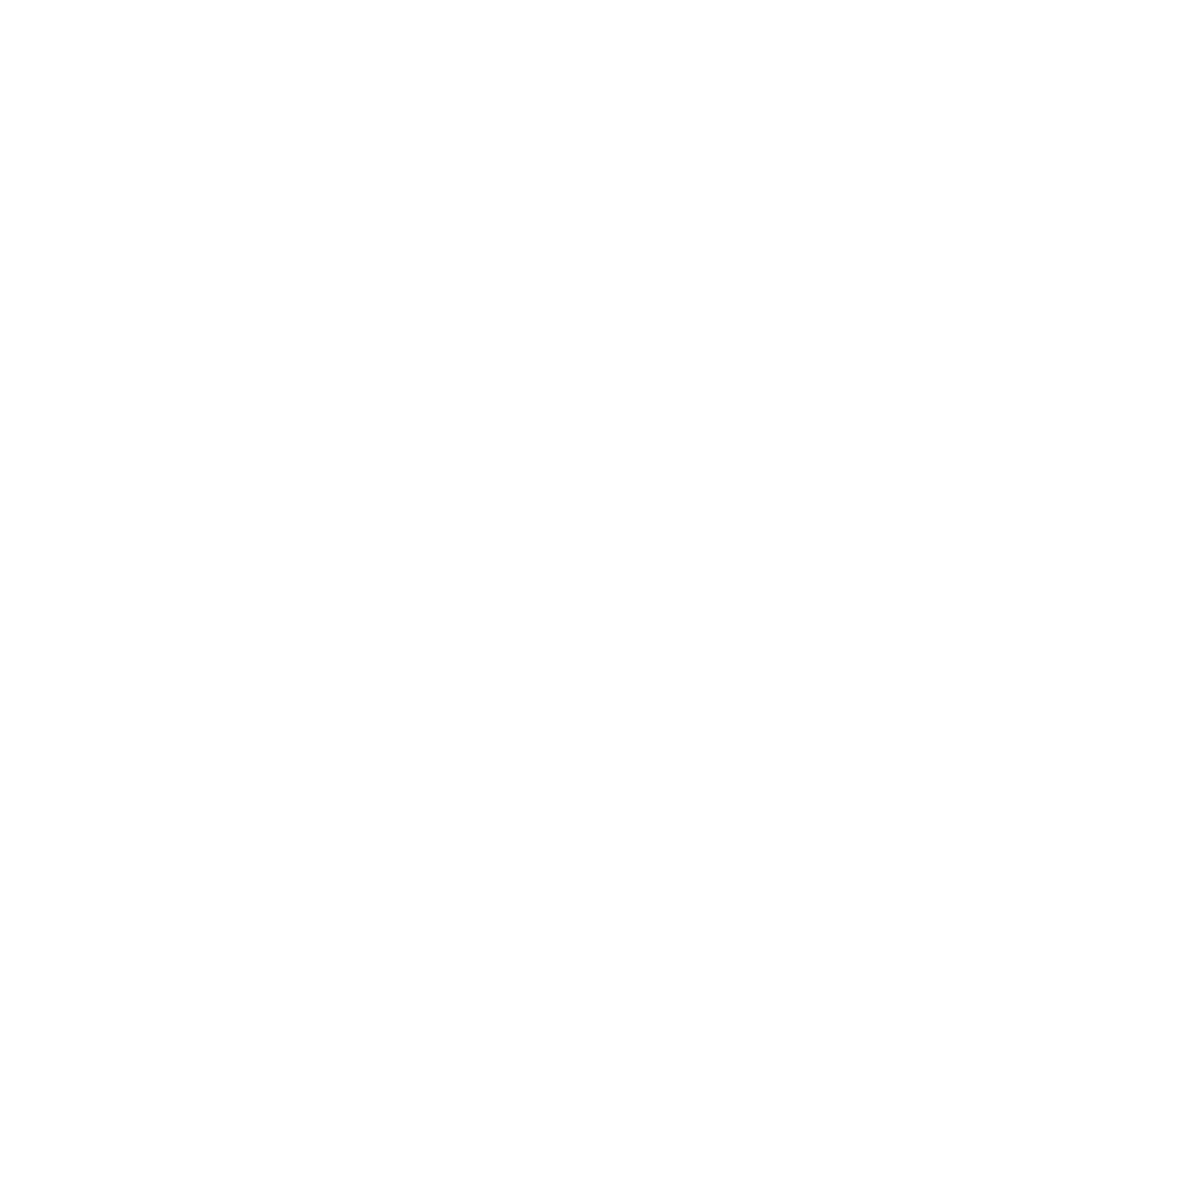

Time taken by compute_p1 is 2.8374717235565186 seconds
Time taken by compute_all is 120.84106040000916 seconds


In [1]:
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
import tensorflow_probability as tfp
import time  
import sim
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

dim = 3
n_particles = int(1e6)
n_subdivisions = 30
save_folder = '../data/L63'
n_steps = 1000
n_repeats = 10
dt = 0.01
r = 1.0
alpha, beta, rho = 10., 8./3., 28.
sigma = 10.
D = sigma**2 / 2.

low=[-20., -20., -20.]
high=[20., 30., 80.]
domain = [low, high]

def mu_np(X):
    x, y, z = np.split(X, dim, axis=-1)
    p = alpha * (y - x) 
    q = x * (rho - z) - y 
    r = x * y - beta * z
    return np.concatenate([p, q, r], axis=-1)

def get_midpoints(x):
    return (x[1:] + x[:-1]) / 2

X0 =  tfp.distributions.MultivariateNormalDiag(scale_diag=tf.ones(dim)).sample(n_particles).numpy()
mc_prob = sim.MCProb(save_folder, n_subdivisions, mu_np, sigma, X0, tick_size=20, title_size=20, cbar_tick_size=15)
#mc_prob.ready(n_steps=n_steps, dt=dt, lims=None)
mc_prob.compute_all(n_steps=n_steps, dt=dt)

In [6]:
def mu(x, y, z):
  p = alpha * (y - x) 
  q = x * (rho - z) - y 
  r = x * y - beta * z
  return p, q, r


@tf.function
def diff_log_op(f, x, y, z):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, z])
        f_ = f(x, y, z)
        f_x, f_y, f_z = tape.gradient(f_, [x, y, z])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    f_zz = tape.gradient(f_z, z)
    p, q, r = mu(x, y, z)
    return -(p*f_x + q*f_y + r*f_z) + (alpha + beta + 1.) + D*(f_xx + f_yy + f_zz + f_x**2 + f_y**2 + f_z**2) 




learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000, 50000], [5e-3, 1e-3, 5e-4, 1e-4, 1e-5])
optimizer = tf.keras.optimizers.Adam(learning_rate)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype='float32', name='L63'.format(dim),\
                                  diff_log_op=diff_log_op, optimizer=optimizer, domain=domain)
solver.learn(epochs = 500, n_sample = 1000, save_folder='../data/L63-true-vs-learned/init', save_along=1, stop_saving=500)

 Epoch        Loss        Runtime(s)
     0 2062.616211            4.0723
    10  197.374451            4.3995
    20  152.260193            4.7064
    30  125.917274            5.0290
    40   97.137344            5.3678
    50   87.165039            5.7079
    60   81.637482            6.0320
    70   73.523613            6.3459
    80   67.773048            6.6776
    90   68.184853            6.9784
   100   60.562599            7.2982
   110   61.640053            7.6063
   120   58.375973            7.9545
   130   56.795650            8.2634
   140   51.339630            8.5836
   150   48.623619            8.9062
   160   49.642612            9.2293
   170   44.590488            9.5341
   180   43.371449            9.8724
   190   42.669853           10.2354
   200   39.469994           10.5400
   210   39.705410           10.8405
   220   36.921909           11.1982
   230   36.451813           11.5403
   240   33.301636           11.8987
   250   35.989189           12.2708
 

  2210    3.012664           76.9935
  2220    3.029336           77.3115
  2230    2.586524           77.6716
  2240    2.831897           78.0507
  2250    2.924832           78.3605
  2260    2.942557           78.6694
  2270    2.381021           79.0194
  2280    2.532856           79.4138
  2290    3.138145           79.7828
  2300    2.771632           80.1089
  2310    3.212706           80.4558
  2320    2.794478           80.8019
  2330    2.491438           81.1011
  2340    2.550032           81.4121
  2350    2.586460           81.7216
  2360    3.329336           82.0269
  2370    2.313844           82.3465
  2380    2.453209           82.6506
  2390    2.562267           82.9713
  2400    2.614331           83.2773
  2410    2.822657           83.5885
  2420    3.697689           83.9135
  2430    2.676430           84.2505
  2440    2.030270           84.6169
  2450    2.583283           85.0020
  2460    2.562472           85.3792
  2470    2.086728           85.6853
 

  4430    1.530354          153.5935
  4440    1.844688          153.9494
  4450    1.481672          154.2544
  4460    1.475487          154.5916
  4470    1.330471          154.9554
  4480    1.680843          155.3869
  4490    1.408917          155.8256
  4500    1.940540          156.1901
  4510    1.822653          156.6201
  4520    1.507960          157.0223
  4530    1.368799          157.4321
  4540    1.821637          157.8401
  4550    1.683736          158.2922
  4560    1.551182          158.7645
  4570    1.345781          159.2193
  4580    1.581638          159.6624
  4590    1.409923          160.0933
  4600    1.656652          160.5216
  4610    1.208274          160.8423
  4620    1.456838          161.1645
  4630    1.615738          161.5276
  4640    1.454465          161.8397
  4650    1.353203          162.1583
  4660    1.154147          162.5302
  4670    1.532249          162.8908
  4680    1.477714          163.2040
  4690    1.660498          163.5350
 

  6650    0.915730          232.8439
  6660    1.299488          233.2347
  6670    1.244992          233.5690
  6680    0.837638          233.9142
  6690    0.952898          234.2459
  6700    1.170960          234.6140
  6710    1.191757          234.9668
  6720    0.967721          235.2834
  6730    1.114479          235.6086
  6740    0.955915          235.9198
  6750    1.024240          236.2204
  6760    1.152914          236.5389
  6770    1.089715          236.8814
  6780    1.055757          237.1901
  6790    0.853959          237.6230
  6800    0.942353          238.0039
  6810    0.960491          238.3297
  6820    0.920391          238.6487
  6830    1.245312          238.9716
  6840    1.021167          239.3428
  6850    1.023622          239.6677
  6860    1.007481          240.0599
  6870    1.050724          240.4062
  6880    0.833666          240.7184
  6890    1.082255          241.1144
  6900    0.898047          241.5448
  6910    0.928199          241.8573
 

  8870    0.758871          308.4835
  8880    0.902859          308.8164
  8890    0.647595          309.1300
  8900    0.566768          309.5102
  8910    0.738754          309.8423
  8920    0.667600          310.1663
  8930    0.906920          310.5141
  8940    0.626663          310.8509
  8950    0.810503          311.2191
  8960    0.773565          311.5623
  8970    0.642455          311.8798
  8980    0.741745          312.2120
  8990    0.802478          312.5651
  9000    0.748363          312.9562
  9010    0.848701          313.2936
  9020    0.712055          313.6500
  9030    0.639459          314.0169
  9040    0.895213          314.3730
  9050    0.602748          314.7014
  9060    1.026394          315.0198
  9070    0.696406          315.3515
  9080    0.776762          315.6812
  9090    0.821244          316.0297
  9100    0.572711          316.3769
  9110    0.760206          316.7267
  9120    0.649054          317.0759
  9130    0.704503          317.4193
 

In [ ]:
solver.net.summary()